### Анализ СМС трафика телеком оператора
У нас есть данные по СМС трафику телеком оператора за январь 2023 года с интервалом 15 минут to do (сделать красивое описание
)


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [13]:
data = pd.read_csv('data/telecom_sms_data.csv', parse_dates=['Event time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Event time  2976 non-null   datetime64[ns]
 1   label       2976 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 46.6 KB


In [15]:
#Отсортируем по дате (чтобы данные были упорядочены по времени)
data.sort_values(by='Event time', ascending=True)

,Event time,label
0,2023-01-01 00:00:00,704
1,2023-01-01 00:15:00,213
2,2023-01-01 00:30:00,126
3,2023-01-01 00:45:00,167
4,2023-01-01 01:00:00,210
...,...,...
2971,2023-01-31 22:45:00,287
2972,2023-01-31 23:00:00,295
2973,2023-01-31 23:15:00,225
2974,2023-01-31 23:30:00,253


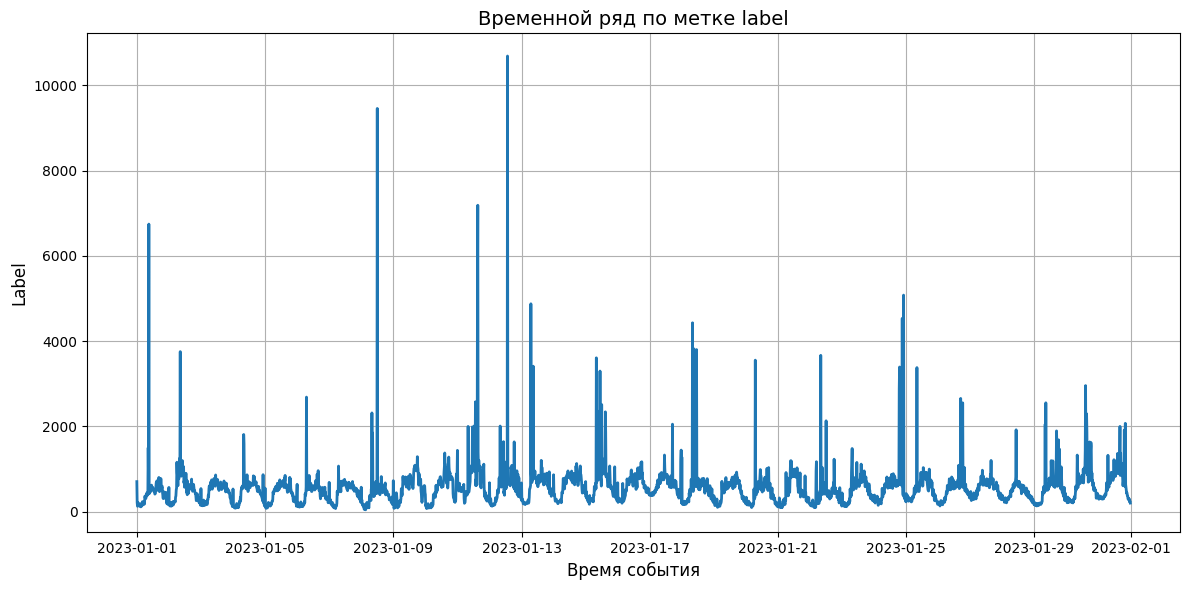

In [19]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(data['Event time'], data['label'], linestyle='-', linewidth=2)

# Оформляем
plt.title('Временной ряд по метке label', fontsize=14)
plt.xlabel('Время события', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

### Декомпозиция временного ряда 
- to do (описать зачем это надо)

In [ ]:
data.set_index('Event time', inplace=True)

<Figure size 1400x800 with 0 Axes>

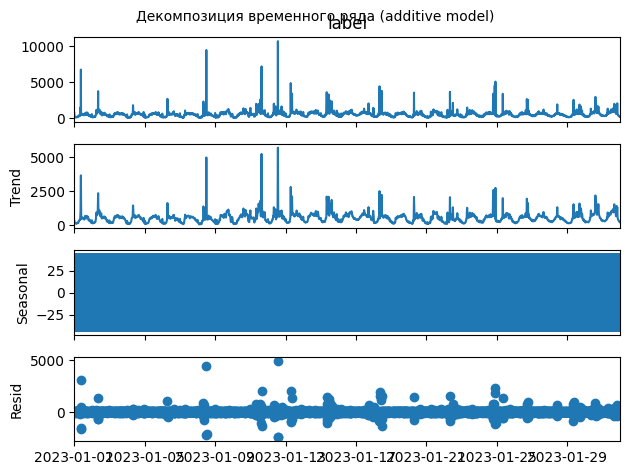

In [28]:

# --- 2. Выполняем декомпозицию ---
# model='additive' подходит, если колебания постоянны по амплитуде
result = seasonal_decompose(data['label'], model='additive', period=2)

# --- 3. Визуализируем ---
plt.figure(figsize=(14, 8))
result.plot()
plt.suptitle('Декомпозиция временного ряда (additive model)', fontsize=10)
plt.show()

to do сделать описание по графикам 

## Проверка стационарности to do описать зачем мы это делаем

In [30]:
result = adfuller(data['label'])

# --- 3. Выводим результаты ---
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

# --- 4. Интерпретация ---
if result[1] <= 0.05:
    print("\n✅ Ряд стационарен (отвергаем H0)")
else:
    print("\n⚠️ Ряд НЕстационарен (не отвергаем H0)")

ADF Statistic: -10.218298
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

✅ Ряд стационарен (отвергаем H0)


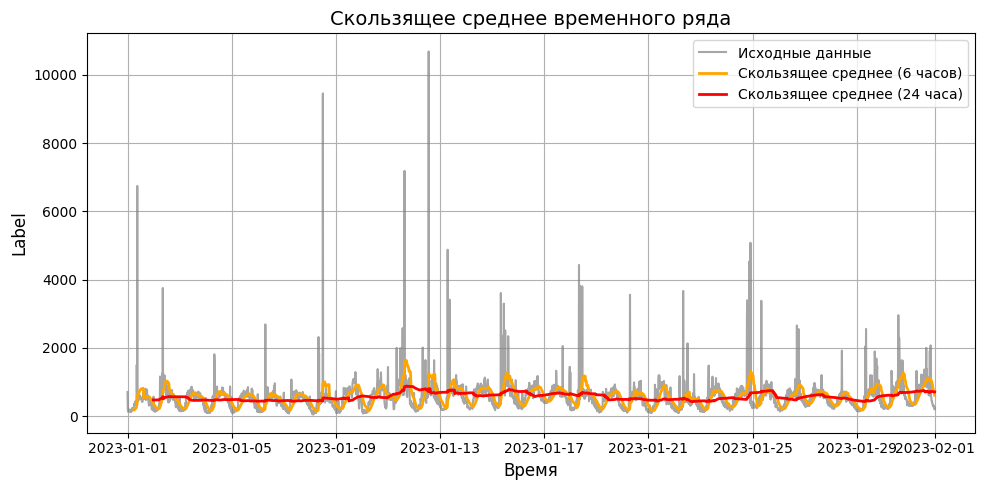

In [31]:
# --- 2. Применяем скользящее среднее ---
# Ряд с интервалом 15 минут → 6 часов = 24 точки, 24 часа = 96 точек
data['MA_6h'] = data['label'].rolling(window=24).mean()
data['MA_24h'] = data['label'].rolling(window=96).mean()

# --- 3. Визуализация ---
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['label'], label='Исходные данные', color='gray', alpha=0.7)
plt.plot(data.index, data['MA_6h'], label='Скользящее среднее (6 часов)', color='orange', linewidth=2)
plt.plot(data.index, data['MA_24h'], label='Скользящее среднее (24 часа)', color='red', linewidth=2)

plt.title('Скользящее среднее временного ряда', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- to do сделать выводы !
- сделать автокореляцию 
- сезонность 

